In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib qt
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import nibabel as nib
import mne
import numpy as np

In [3]:
SUBJECT_DIR = "/home/carlos/Datasets/subjects/MNIAverage"
CEREBRA_DIR = "/home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62"

In [4]:
def inspect_img(path):
    img = nib.load(path)
    data = img.get_fdata()
    img.orthoview()
    print(f"{img.shape= }")
    print(nib.orientations.aff2axcodes(img.affine))
    return img, data 

img.shape= (193, 229, 193)
('R', 'A', 'S')


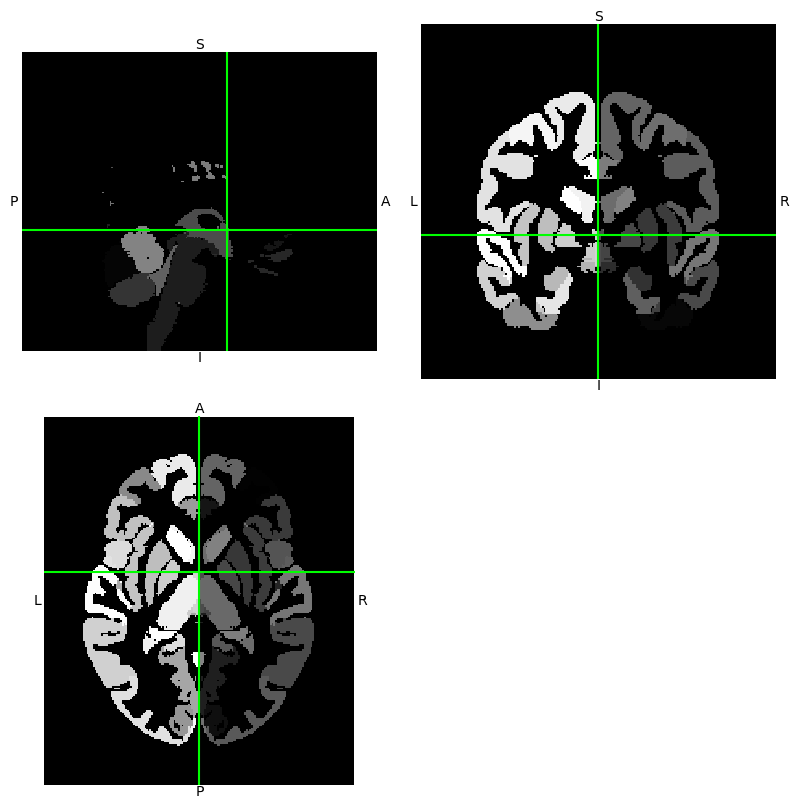

In [5]:
cerebra_nii_img, cerebra_nii_data = inspect_img(f"{CEREBRA_DIR}/CerebrA.nii")

img.shape= (256, 256, 256)
('L', 'I', 'A')


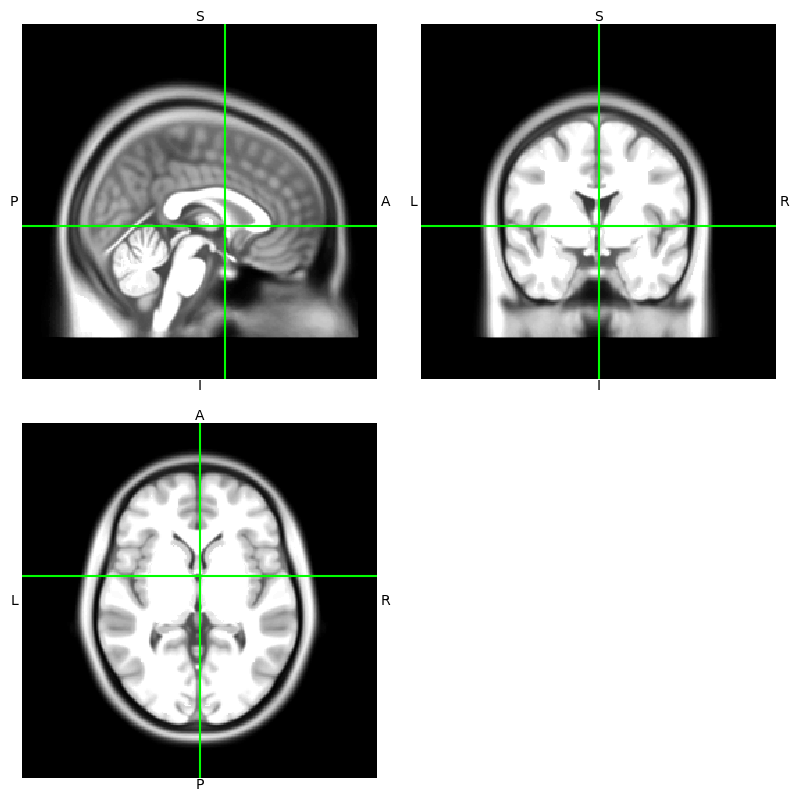

In [34]:
t1_img, t1_data = inspect_img(f"{SUBJECT_DIR}/mri/T1.mgz")

img.shape= (256, 256, 256)
('L', 'I', 'A')


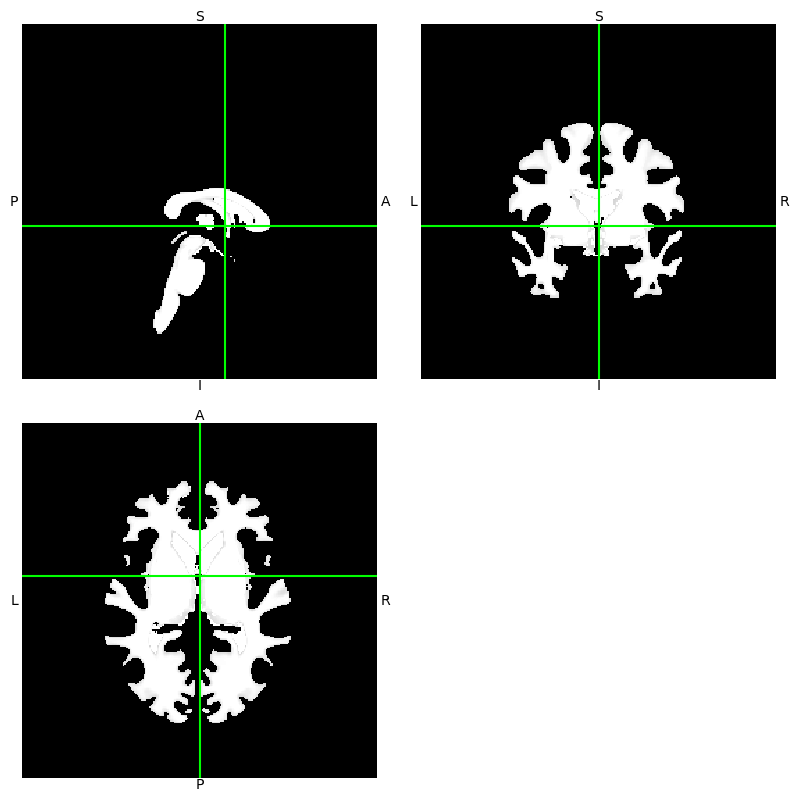

In [22]:
img, data = inspect_img(f"{SUBJECT_DIR}/mri/wm.mgz")


### Transform .nii to .mgz

In [7]:
!mri_convert $CEREBRA_DIR"/CerebrA.nii" $CEREBRA_DIR"/CerebrA.mgz"

mri_convert /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.nii /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.mgz 
reading from /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.nii...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
writing to /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.mgz...


### Switch to head coordinate frame and store in CerebrA_in_head.mgz

In [8]:
!mri_vol2vol --mov $CEREBRA_DIR"/CerebrA.mgz" --o $CEREBRA_DIR"/CerebrA_in_head.mgz" --regheader --targ $SUBJECT_DIR/mri/T1.mgz --interp nearest

movvol /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA.mgz
targvol /home/carlos/Datasets/subjects/MNIAverage/mri/T1.mgz
outvol /home/carlos/Datasets/Cerebra/10.12751_g-node.be5e62/CerebrA_in_head.mgz
invert 0
tal    0
talres 2
regheader 1
noresample 0
interp  nearest (0)
precision  float (3)
Gdiag_no  -1
Synth      0
SynthSeed  1695345197

Computing registration based on scanner-to-scanner

Final tkRAS-to-tkRAS Matrix is:
-1.00000   0.00000   0.00000   0.00000;
 0.00000   0.00000   1.00000   0.00000;
 0.00000  -1.00000   0.00000   0.00000;
 0.00000   0.00000   0.00000   1.00000;


Vox2Vox Matrix is:
-1.00000   0.00000   0.00000   224.50000;
 0.00000   0.00000   1.00000  -13.50000;
 0.00000  -1.00000   0.00000   224.50000;
 0.00000   0.00000   0.00000   1.00000;

Resampling
Output registration matrix is identity

mri_vol2vol done


img.shape= (193, 229, 193)
('R', 'A', 'S')


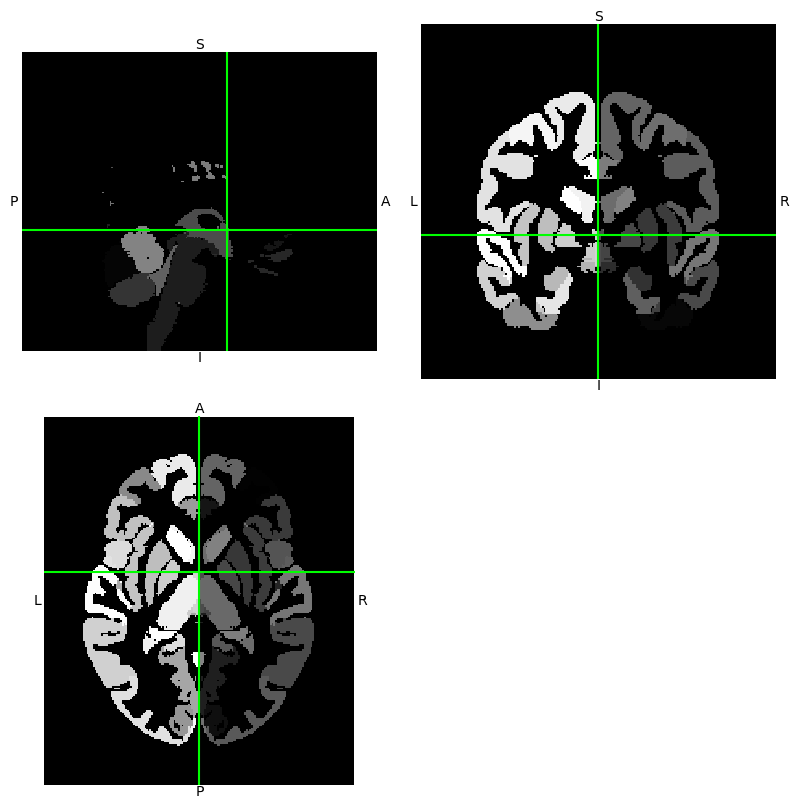

In [9]:
cerebra_mgz_img, cerebra_mgz_data = inspect_img(f"{CEREBRA_DIR}/CerebrA.mgz")

img.shape= (256, 256, 256)
('L', 'I', 'A')


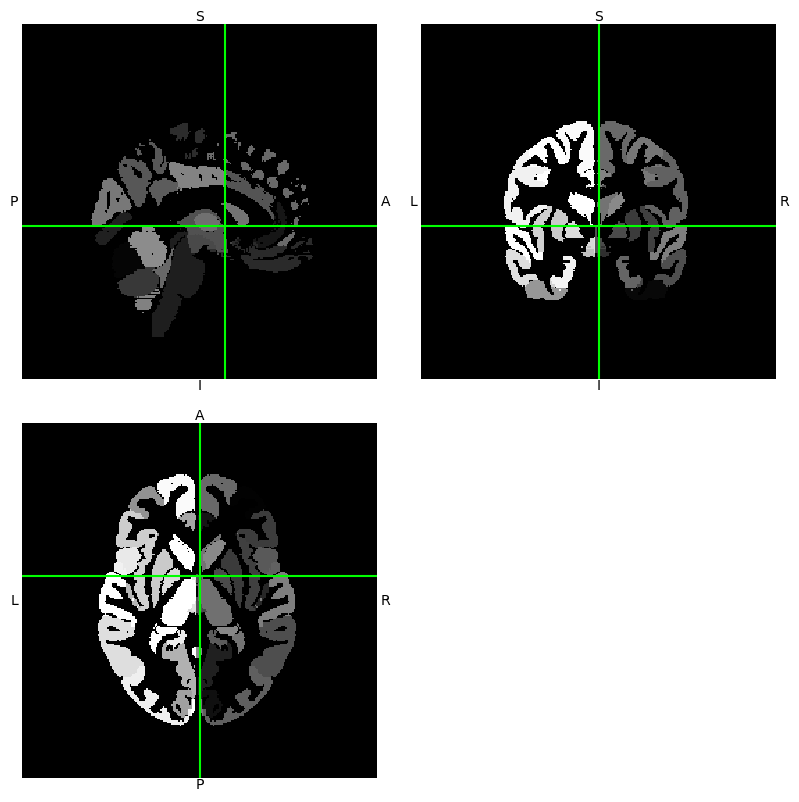

In [10]:
cerebra_in_head_img, cerebra_in_head_data = inspect_img(f"{CEREBRA_DIR}/CerebrA_in_head.mgz")

### Coordinate frame transforms

In [11]:
print(nib.orientations.aff2axcodes(t1_img.affine))

('L', 'I', 'A')


<AxesSubplot:xlabel='Y (I)', ylabel='Z (A)'>

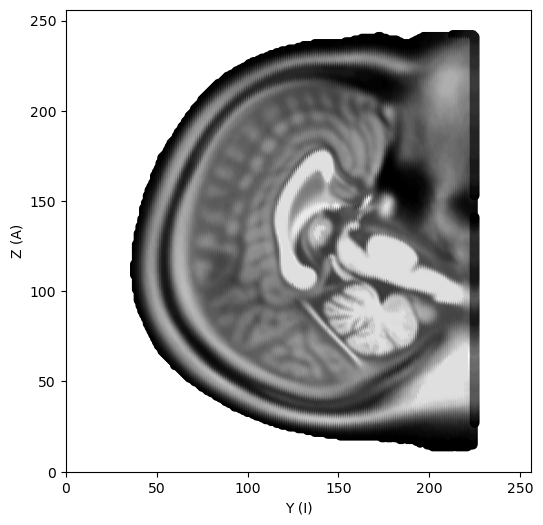

In [12]:
from cerebra_atlas_python.plotting import imshow_mri, plot_brain_slice_2D
plot_brain_slice_2D(t1_data, t1_img.affine, cmap_name="gray")

In [13]:
from cerebra_atlas_python.utils import move_volume_from_LIA_to_RAS

In [14]:
t1_data = move_volume_from_LIA_to_RAS(t1_data, t1_img.affine)

After transforming the volume, the affine is not correct and should also be transformed

<AxesSubplot:xlabel='Y (I)', ylabel='Z (A)'>

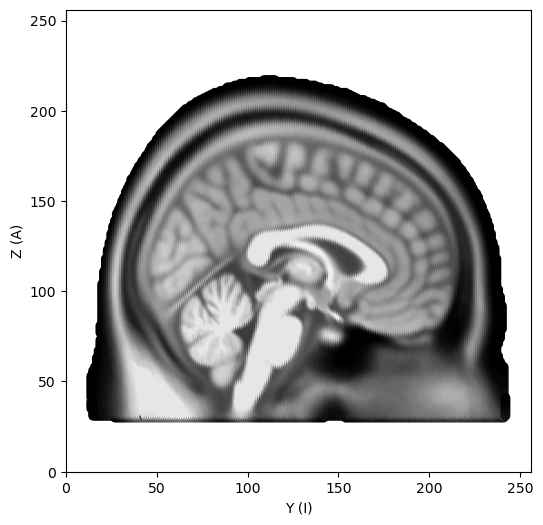

In [16]:
# The affine matrix should also be modified to be in RAS
plot_brain_slice_2D(t1_data, t1_img.affine, cmap_name="gray")

In [18]:
print(nib.orientations.aff2axcodes(t1_img.affine))
t1_img.affine

('L', 'I', 'A')


array([[  -1. ,    0. ,    0. ,  128.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,   -1. ,    0. ,  146.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [20]:
cerebra_mgz_data.shape

(193, 229, 193)

In [19]:
print(nib.orientations.aff2axcodes(cerebra_mgz_img.affine))
cerebra_mgz_img.affine

('R', 'A', 'S')


array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [23]:
import numpy as np

In [25]:
pt = np.array([1,10,100])

In [26]:
mne.transforms.apply_trans(cerebra_mgz_img.affine,pt)

array([ -95., -122.,   22.])

In [27]:
mne.transforms.apply_trans(t1_img.affine,pt)

array([127.5, -45.5, 136.5])

### Transform affine matrix

In [45]:
aff = t1_img.affine.copy()
print(nib.orientations.aff2axcodes(aff))
aff

('L', 'I', 'A')


array([[  -1. ,    0. ,    0. ,  128.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,   -1. ,    0. ,  146.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [46]:
aff[1,:] = t1_img.affine[2,:]
aff[2,:] = t1_img.affine[1,:]
print(nib.orientations.aff2axcodes(aff))
aff

('L', 'P', 'S')


array([[  -1. ,    0. ,    0. ,  128.5],
       [   0. ,   -1. ,    0. ,  146.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [47]:
aff[0,:] = aff[0,:] * -1
aff[1,:] = aff[1,:] * -1
print(nib.orientations.aff2axcodes(aff))
aff

('R', 'A', 'S')


array([[   1. ,   -0. ,   -0. , -128.5],
       [  -0. ,    1. ,   -0. , -146.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [44]:
print(nib.orientations.aff2axcodes(aff))

('R', 'A', 'S')
